# From .FIT -> .csv

## How .FIT files are structured

``` FIT File = Header + Data Records + CRC ```

#### Record Messages
Location: `fit_data['record_mesgs']` - this is an array of timestamped data points

Frequency: Written every 1-2 seconds during activity recording

Contents:
- Standard data: timestamp, heart_rate, distance, speed, cadence
- Your custom sensor data: Appears as numbered fields (like 135: 176, 136: 73)
- GPS data: latitude, longitude, altitude (when available)

#### High Frequency Data
-  Accel/Gyro Data is Stored in Blocks (beacause of efficiency and different data rates )
- Instead of creating 25 separate record messages per second, Garmin batches them into arrays

#### What Data will look like

```python
# Low-frequency data = individual values per record
'record_mesgs': [{'timestamp': 16:46:14, 'heart_rate': 72}]

# High-frequency data = arrays of 25 values per batch    
'accelerometer_data_mesgs': [{                           
    'timestamp': 16:46:13,                               
    'calibrated_accel_x': [-298.09, -162.75, -271.42, ...], # 25 samples
    'sample_time_offset': [0, 19, 27, 39, 48, ...]          # Timing within batch
}]

```

In [90]:
from garmin_fit_sdk import Decoder, Stream
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.dates as mdates

import plotly.express as px


####################
# For plotting on a map
import folium
from folium import plugins
###################

In [94]:
FIT_FILE_LOCATION = "/home/kuba/Documents/garmin-data-viz/brett/data/01/left/2025-08-22-14-32-42/2025-08-23-02-32-49.fit"
# FILE_NAME = 'test_recording'
# CSV_SAVE_LOCATION = f"~/Desktop/{FILE_NAME}.csv"

In [95]:
stream = Stream.from_file(FIT_FILE_LOCATION)
decoder = Decoder(stream)
messages, errors = decoder.read()

In [96]:
print('errors: ',errors)

errors:  []


In [97]:
diff  = messages['record_mesgs'][-1]['timestamp'] - messages['record_mesgs'][0]['timestamp'] 
days = diff.days
hours = diff.seconds // 3600 
mins = (diff.seconds % 3600) // 60
secs = diff.seconds % 60

print(f" RECORDING LENGTH: {days:02}d {hours:02}h {mins:02}m {secs}s")

 RECORDING LENGTH: 00d 02h 59m 58s


In [98]:
gps_vaild = [1 if 'position_lat' in dic.keys() else 0 for dic in messages['record_mesgs']] # for each record mesg true if gps location recorded else false
total_mesgs = len(messages['record_mesgs'])

total_secs = (diff.days * 24 * 60 *60) + diff.seconds

print(f"{total_mesgs} record mesgs at {total_secs/total_mesgs:.1f} sec/record")
print(f"{sum(gps_vaild)} with GPS data at {(sum(gps_vaild) / total_mesgs)*100:.2f}% of all mesgs")

517 record mesgs at 20.9 sec/record
517 with GPS data at 100.00% of all mesgs


In [99]:
print('Accelerometer data we have ',len(messages['accelerometer_data_mesgs']),' groups of data')
print('Each group has ',len(messages['accelerometer_data_mesgs'][1]['calibrated_accel_x']),'sampled points')
print('In total we have',len(messages['accelerometer_data_mesgs']) * len(messages['accelerometer_data_mesgs'][1]['calibrated_accel_x']),'sampled points in the whole fit file')
print('\n','-'*60,'\n')
print('Gyroscope data we have ',len(messages['gyroscope_data_mesgs']),' groups of data')
print('Each group has ',len(messages['gyroscope_data_mesgs'][1]['calibrated_gyro_x']),'sampled points')
print('In total we have',len(messages['gyroscope_data_mesgs']) * len(messages['gyroscope_data_mesgs'][1]['calibrated_gyro_x']),'sampled points in the whole fit file')

Accelerometer data we have  43056  groups of data
Each group has  25 sampled points
In total we have 1076400 sampled points in the whole fit file

 ------------------------------------------------------------ 

Gyroscope data we have  43052  groups of data
Each group has  25 sampled points
In total we have 1076300 sampled points in the whole fit file


In [100]:
messages['record_mesgs'][-1]

{'timestamp': datetime.datetime(2025, 8, 23, 10, 32, 47, tzinfo=datetime.timezone.utc),
 'position_lat': 464375244,
 'position_long': -1102408602,
 'enhanced_speed': 0.0,
 107: 0,
 'developer_fields': {0: 78.0, 1: 0, 2: 0}}

In [101]:
messages['file_id_mesgs'][0]['serial_number']

3507164377

In [103]:
messages

{'file_id_mesgs': [{'serial_number': 3507164377,
   'time_created': datetime.datetime(2025, 8, 23, 7, 33, 27, tzinfo=datetime.timezone.utc),
   'manufacturer': 'garmin',
   'product': 4575,
   'type': 'activity',
   'garmin_product': 'enduro3'}],
 'file_creator_mesgs': [{'software_version': 1728}],
 'activity_mesgs': [{'timestamp': datetime.datetime(2025, 8, 23, 7, 32, 49, tzinfo=datetime.timezone.utc),
   'total_timer_time': 10800.567,
   'local_timestamp': 1124850769,
   'num_sessions': 1,
   'type': 'manual',
   'event': 'activity',
   'event_type': 'stop'}],
 'developer_data_id_mesgs': [{'application_id': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0],
   'application_version': 0,
   'developer_data_index': 0}],
 'session_mesgs': [{'timestamp': datetime.datetime(2025, 8, 23, 7, 32, 49, tzinfo=datetime.timezone.utc),
   'start_time': datetime.datetime(2025, 8, 23, 7, 32, 49, tzinfo=datetime.timezone.utc),
   'start_positi

In [102]:
#create the dataframeß
df_high_freq_data = pd.DataFrame(columns=['timestamp', 'x_accel', 'y_accel', 'z_accel', 'x_gyro', 'y_gyro', 'z_gyro'])
df_low_freq_data = pd.DataFrame(columns=['timestamp', 'position_lat', 'position_long', 'heart_rate'])
df_event_self_reports = pd.DataFrame(columns=['start_timestamp', 'end_timestamp', 'event_type'])

In [81]:
# add a group to the dataframe
def add_to_df_high_freq_data(df, x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro, timestamp, timestamp_ms, sample_time_offset):
    if not (len(x_accel) == len(y_accel) == len(z_accel) == len(sample_time_offset)) or not (len(x_gyro) == len(y_gyro) == len(z_gyro) == len(sample_time_offset)) or not (len(x_accel) == len(x_gyro)):
        raise ValueError("All input lists must have the same length")

    
    precise_base_timestamp = timestamp.replace(microsecond=timestamp_ms*1000)
    
    start_idx = len(df)
    
    for i in range(len(x_gyro)):
        sample_timestamp = precise_base_timestamp + datetime.timedelta(milliseconds=sample_time_offset[i])
        df.loc[start_idx + i] = [sample_timestamp, x_accel[i], y_accel[i], z_accel[i], x_gyro[i], y_gyro[i], z_gyro[i]]
    
    return df

In [82]:
# iterate over all groups to add to the df
for group in tqdm(range(len(messages['accelerometer_data_mesgs']))):
    df_high_freq_data = add_to_df_high_freq_data(df_high_freq_data, 
                   messages['accelerometer_data_mesgs'][group]['calibrated_accel_x'], 
                   messages['accelerometer_data_mesgs'][group]['calibrated_accel_y'], 
                   messages['accelerometer_data_mesgs'][group]['calibrated_accel_z'],

                   messages['gyroscope_data_mesgs'][group]['calibrated_gyro_x'], 
                   messages['gyroscope_data_mesgs'][group]['calibrated_gyro_y'], 
                   messages['gyroscope_data_mesgs'][group]['calibrated_gyro_z'],
                   
                   messages['accelerometer_data_mesgs'][group]['timestamp'], 
                   messages['accelerometer_data_mesgs'][group]['timestamp_ms'], 

                   messages['accelerometer_data_mesgs'][group]['sample_time_offset'])

  0%|          | 42/43112 [00:04<1:17:27,  9.27it/s]


KeyboardInterrupt: 

In [83]:
vaild_event_types = {1, 2}
def process_self_reports(timestamp, event_type, df_event_self_reports, is_event_active, is_event_active_Field):
    if event_type in vaild_event_types:

        if (not is_event_active) and (is_event_active_Field == 1): #just switched the event on
            df_event_self_reports = pd.concat([df_event_self_reports, pd.DataFrame([{'start_timestamp': timestamp, 'end_timestamp': pd.NA, 'event_type':event_type}])], ignore_index=True )
            is_event_active =  True

        elif (is_event_active) and (is_event_active_Field == 0): #jsut switched the even off
            df_event_self_reports.at[df_event_self_reports.index[-1], 'end_timestamp'] = timestamp
            is_event_active = False

    return df_event_self_reports, is_event_active

In [84]:
is_event_active = False
for mesg in messages['record_mesgs']:
    position_lat = mesg['position_lat'] if 'position_lat' in mesg.keys() else np.nan
    position_long = mesg['position_long'] if 'position_lat' in mesg.keys() else np.nan
    heart_rate = mesg['heart_rate'] if 'heart_rate' in mesg.keys() else np.nan
    battery = mesg['developer_fields'][0]

    df_low_freq_data = pd.concat([df_low_freq_data, pd.DataFrame([{'timestamp': mesg['timestamp'], 'position_lat':position_lat, 'position_long':position_long, 'heart_rate':heart_rate, 'battery':battery}])], ignore_index=True )

    is_event_active_Field =  mesg['developer_fields'][1] #is_event_active_Field this valie is one if we are recroding and anythin else if we are not recording
    event_type = mesg['developer_fields'][2] # event type
    df_event_self_reports, is_event_active = process_self_reports(mesg['timestamp'], event_type, df_event_self_reports, is_event_active, is_event_active_Field)

df_low_freq_data['timestamp'] = df_low_freq_data['timestamp'].dt.tz_convert('US/Eastern')

/tmp/ipykernel_51196/1368032208.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_low_freq_data = pd.concat([df_low_freq_data, pd.DataFrame([{'timestamp': mesg['timestamp'], 'position_lat':position_lat, 'position_long':position_long, 'heart_rate':heart_rate, 'battery':battery}])], ignore_index=True )


KeyError: 1

In [85]:
messages['record_mesgs'][-1]

{'timestamp': datetime.datetime(2025, 6, 9, 17, 22, 28, tzinfo=datetime.timezone.utc),
 'developer_fields': {0: 63.0}}

In [86]:
df_event_self_reports

Empty DataFrame
Columns: [start_timestamp, end_timestamp, event_type]
Index: []

Text(0, 0.5, 'Battery %')

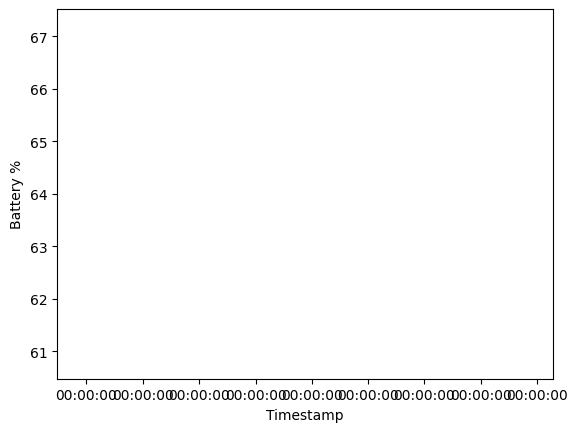

In [87]:
plt.plot(df_low_freq_data['timestamp'],df_low_freq_data['battery'])

time_formatter = mdates.DateFormatter('%H:%M:%S')  # Format as HH:MM:SS
plt.gca().xaxis.set_major_formatter(time_formatter)

plt.xlabel("Timestamp")
plt.ylabel("Battery %")

In [88]:
df_high_freq_data.head(10)

timestamp    x_accel    y_accel     z_accel  \
0 2025-06-09 14:23:33.208000+00:00  17.238573 -12.924669 -995.945435   
1 2025-06-09 14:23:33.217000+00:00  15.266944 -10.000268 -998.846558   
2 2025-06-09 14:23:33.226000+00:00  17.238573 -15.849071 -997.879517   
3 2025-06-09 14:23:33.237000+00:00  18.224386 -16.823872 -996.912476   
4 2025-06-09 14:23:33.246000+00:00  13.295315 -11.949869 -994.011414   
5 2025-06-09 14:23:33.256000+00:00  16.252758  -8.050667 -994.011414   
6 2025-06-09 14:23:33.265000+00:00  17.238573 -10.975068 -993.044373   
7 2025-06-09 14:23:33.275000+00:00  19.210201 -12.924669 -994.011414   
8 2025-06-09 14:23:33.286000+00:00  18.224386 -13.899469 -999.813538   
9 2025-06-09 14:23:33.293000+00:00  12.309501  -9.025468 -992.077332   

     x_gyro    y_gyro    z_gyro  
0 -0.022843  0.049014  0.004806  
1  0.047157 -0.020986  0.004806  
2 -0.197843 -0.020986 -0.065194  
3 -0.197843  0.049014 -0.030194  
4  0.012157  0.049014 -0.100194  
5 -0.022843  0.014014 -0.170194  
6 -0.022843 -0.090986 -0.065194  
7  0.012157  0.014014 -0.065194  
8  0.012157  0.014014 -0.170194  
9  0.047157  0.014014 -0.135194

In [73]:
df_high_freq_data.tail(10)

timestamp     x_accel     y_accel      z_accel  \
5990 2025-09-05 00:24:32.145000+00:00  -65.569824  156.690598  -956.297363   
5991 2025-09-05 00:24:32.153000+00:00  -81.342857  109.900192  -960.165466   
5992 2025-09-05 00:24:32.162000+00:00   45.827187 -275.145966  -908.912964   
5993 2025-09-05 00:24:32.172000+00:00   15.266944  284.389465  -889.572388   
5994 2025-09-05 00:24:32.181000+00:00 -137.534256  456.929138  -951.462219   
5995 2025-09-05 00:24:32.191000+00:00 -165.137070  424.760742  -990.143311   
5996 2025-09-05 00:24:32.201000+00:00 -111.903091  254.170654 -1001.747620   
5997 2025-09-05 00:24:32.210000+00:00   15.266944  117.698593  -960.165466   
5998 2025-09-05 00:24:32.222000+00:00  129.621399  110.874985  -939.857849   
5999 2025-09-05 00:24:32.229000+00:00   77.373245  117.698593  -871.198853   

         x_gyro     y_gyro      z_gyro  
5990  -9.163367 -16.777733   -0.280142  
5991   4.696634 -12.857733   11.619858  
5992  10.541634 -11.422732   16.099857  
5993   7.601634 -16.847733   24.114857  
5994  -0.833367 -22.937735   26.354858  
5995   0.216633 -35.747730   16.449858  
5996   5.501634 -47.507732    5.424858  
5997  19.851633 -51.637733   98.454857  
5998   8.651633 -13.277733  124.774857  
5999  13.831634  -5.507733   84.209862

In [23]:
(df_high_freq_data.iloc[8152]['timestamp']).tz_convert('America/New_York')

Timestamp('2025-09-06 06:07:37.862000-0400', tz='America/New_York')

In [27]:


conversion_factor = 180 / (2**31)
df_low_freq_data['lat'] = df_low_freq_data['position_lat'] * conversion_factor
df_low_freq_data['lon'] = df_low_freq_data['position_long'] * conversion_factor

# Convert timestamp to datetime
df_low_freq_data['timestamp'] = pd.to_datetime(df_low_freq_data['timestamp'])

print(f"Original dataset size: {len(df_low_freq_data)} rows")
df_clean = df_low_freq_data.dropna(subset=['lat', 'lon', 'heart_rate']).copy()
print(f"After removing NaN values: {len(df_clean)} rows")

def create_gps_map(df):
    """
    Create an interactive map showing GPS tracking data with heart rate information
    """
    
    # Calculate center point for the map
    center_lat = df['lat'].mean()
    center_lon = df['lon'].mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=18,  # High zoom for detailed view
        tiles='OpenStreetMap'
    )
    
    # Create a color map for heart rate (green = low, red = high)
    def get_color(heart_rate):
        if heart_rate < 60:
            return 'green'
        elif heart_rate < 80:
            return 'orange'
        else:
            return 'red'
    
    # Add markers for each GPS point
    for idx, row in df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            popup=f"""
            <b>Time:</b> {row['timestamp'].strftime('%H:%M:%S')}<br>
            <b>Heart Rate:</b> {row['heart_rate']} bpm<br>
            <b>Coordinates:</b> {row['lat']:.6f}, {row['lon']:.6f}
            """,
            color=get_color(row['heart_rate']),
            fillColor=get_color(row['heart_rate']),
            fillOpacity=0.8,
            weight=2
        ).add_to(m)
    
    # Create the path line
    coordinates = [[row['lat'], row['lon']] for _, row in df.iterrows()]
    folium.PolyLine(
        coordinates,
        color='blue',
        weight=3,
        opacity=0.8
    ).add_to(m)
    
    # Add start and end markers
    folium.Marker(
        location=[df.iloc[0]['lat'], df.iloc[0]['lon']],
        popup='Start',
        icon=folium.Icon(color='green', icon='play')
    ).add_to(m)
    
    folium.Marker(
        location=[df.iloc[-1]['lat'], df.iloc[-1]['lon']],
        popup='End',
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(m)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 150px; height: 90px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p><b>Heart Rate Legend</b></p>
    <p><i class="fa fa-circle" style="color:green"></i> < 60 bpm</p>
    <p><i class="fa fa-circle" style="color:orange"></i> 60-80 bpm</p>
    <p><i class="fa fa-circle" style="color:red"></i> > 80 bpm</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create and display the map
map_obj = create_gps_map(df_clean)
# display(map_obj)
map_obj.save('temp_map.html')

Original dataset size: 1361 rows
After removing NaN values: 1361 rows


Lets take a look at it

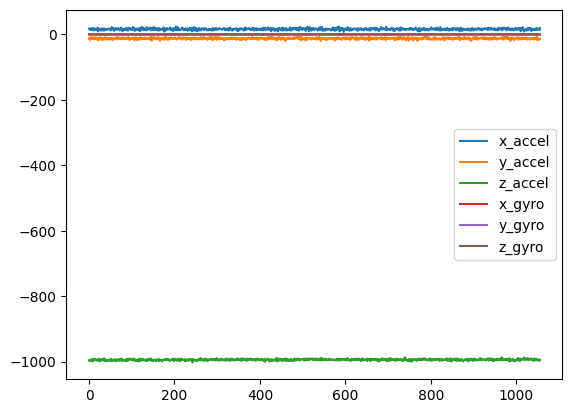

In [89]:
import matplotlib.pyplot as plt
plt.plot(df_high_freq_data['x_accel'], label='x_accel')
plt.plot(df_high_freq_data['y_accel'], label='y_accel')
plt.plot(df_high_freq_data['z_accel'], label='z_accel')

plt.plot(df_high_freq_data['x_gyro'], label='x_gyro')
plt.plot(df_high_freq_data['y_gyro'], label='y_gyro')
plt.plot(df_high_freq_data['z_gyro'], label='z_gyro')
plt.legend()
plt.show()


In [83]:
# df_high_freq_data['self_report'] = 0
# for self_report in range(len(df_event_self_reports)):
#     mask = (df_high_freq_data['timestamp'] >= df_event_self_reports.iloc[self_report]['start_timestamp']) & (df_high_freq_data['timestamp'] <= df_event_self_reports.iloc[self_report]['end_timestamp'])
#     df_high_freq_data.loc[mask, 'self_report'] = df_event_self_reports.iloc[self_report]['event_type'] * 10


In [84]:
def add_lables_to_df(df_data, df_lables, multiplier=10):
    df_data['self_report'] = 0
    for self_report in range(len(df_lables)):
        mask = (df_data['timestamp'] >= df_lables.iloc[self_report]['start_timestamp']) & (df_data['timestamp'] <= df_lables.iloc[self_report]['end_timestamp'])
        df_data.loc[mask, 'self_report'] = df_lables.iloc[self_report]['event_type'] * multiplier

    return df_data

In [85]:
df_high_freq_data = add_lables_to_df(df_high_freq_data, df_event_self_reports, multiplier=1000)

df_low_freq_data = add_lables_to_df(df_low_freq_data, df_event_self_reports, multiplier=10)

In [29]:
fig = px.line(df_high_freq_data, x='timestamp', y=['x_accel', 'y_accel', 'z_accel', 'self_report'])
fig.show()

ValueError: All arguments should have the same length. The length of argument `y` is 4, whereas the length of previously-processed arguments ['timestamp'] is 62272

In [30]:
df_low_freq_data['heart_rate'] = df_low_freq_data['heart_rate'].astype(int)

In [31]:
df_low_freq_data

timestamp position_lat position_long  heart_rate  \
0    2025-09-06 06:05:51-04:00    408440123    -961751872          74   
1    2025-09-06 06:06:17-04:00    408440619    -961751810          78   
2    2025-09-06 06:06:19-04:00    408440619    -961751810          75   
3    2025-09-06 06:06:22-04:00    408440619    -961751810          71   
4    2025-09-06 06:06:26-04:00    408440619    -961751810          68   
...                        ...          ...           ...         ...   
1356 2025-09-06 09:04:58-04:00    408443046    -961749217          81   
1357 2025-09-06 09:05:15-04:00    408443046    -961749217          85   
1358 2025-09-06 09:05:22-04:00    408443046    -961749217          88   
1359 2025-09-06 09:05:25-04:00    408443046    -961749217          88   
1360 2025-09-06 09:05:44-04:00    408443046    -961749217          87   

      battery        lat        lon  
0        73.0  34.235056 -80.613111  
1        73.0  34.235097 -80.613105  
2        73.0  34.235097 -80.613105  
3        73.0  34.235097 -80.613105  
4        73.0  34.235097 -80.613105  
...       ...        ...        ...  
1356     70.0  34.235301 -80.612888  
1357     70.0  34.235301 -80.612888  
1358     70.0  34.235301 -80.612888  
1359     70.0  34.235301 -80.612888  
1360     70.0  34.235301 -80.612888  

[1361 rows x 7 columns]

In [ ]:
fig = px.line(df_low_freq_data, x='timestamp', y=['heart_rate', 'self_report'])
fig.show()

/home/kuba/.virenv/base/lib/python3.12/site-packages/plotly/express/_core.py:1408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  args[field_name][i] = str(col_name)


KeyError: 0

Now lests save it

In [ ]:
df.to_csv(CSV_SAVE_LOCATION, index=False)

NameError: name 'df' is not defined